# Rossman Data Seti

Bu çalışmanın amacı Rossman mağzalarının günlük cirolarını tahmin eden bir model ortaya koymaktır. Veri ön işleme yapılıp, denetimli makine öğrenmesinin karar ağaçları modelleri oluşturulacaktır.

<ipython-input-1-db1e95848b0c>:50: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  veri["Hafta"]=veri["Date"].dt.week


Store                         0.000000
DayOfWeek                     0.000000
Date                          0.000000
Sales                         0.000000
Customers                     0.000000
Open                          0.000000
Promo                         0.000000
StateHoliday                  0.000000
SchoolHoliday                 0.000000
StoreType                     0.000000
Assortment                    0.000000
CompetitionDistance           0.259730
CompetitionOpenSinceMonth    31.787764
CompetitionOpenSinceYear     31.787764
Promo2                        0.000000
Promo2SinceWeek              49.943620
Promo2SinceYear              49.943620
PromoInterval                49.943620
Gün                           0.000000
Hafta                         0.000000
Ay                            0.000000
Yıl                           0.000000
Mevsim                        0.000000
dtype: float64
(203442, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203442 entries, 0 to 2034

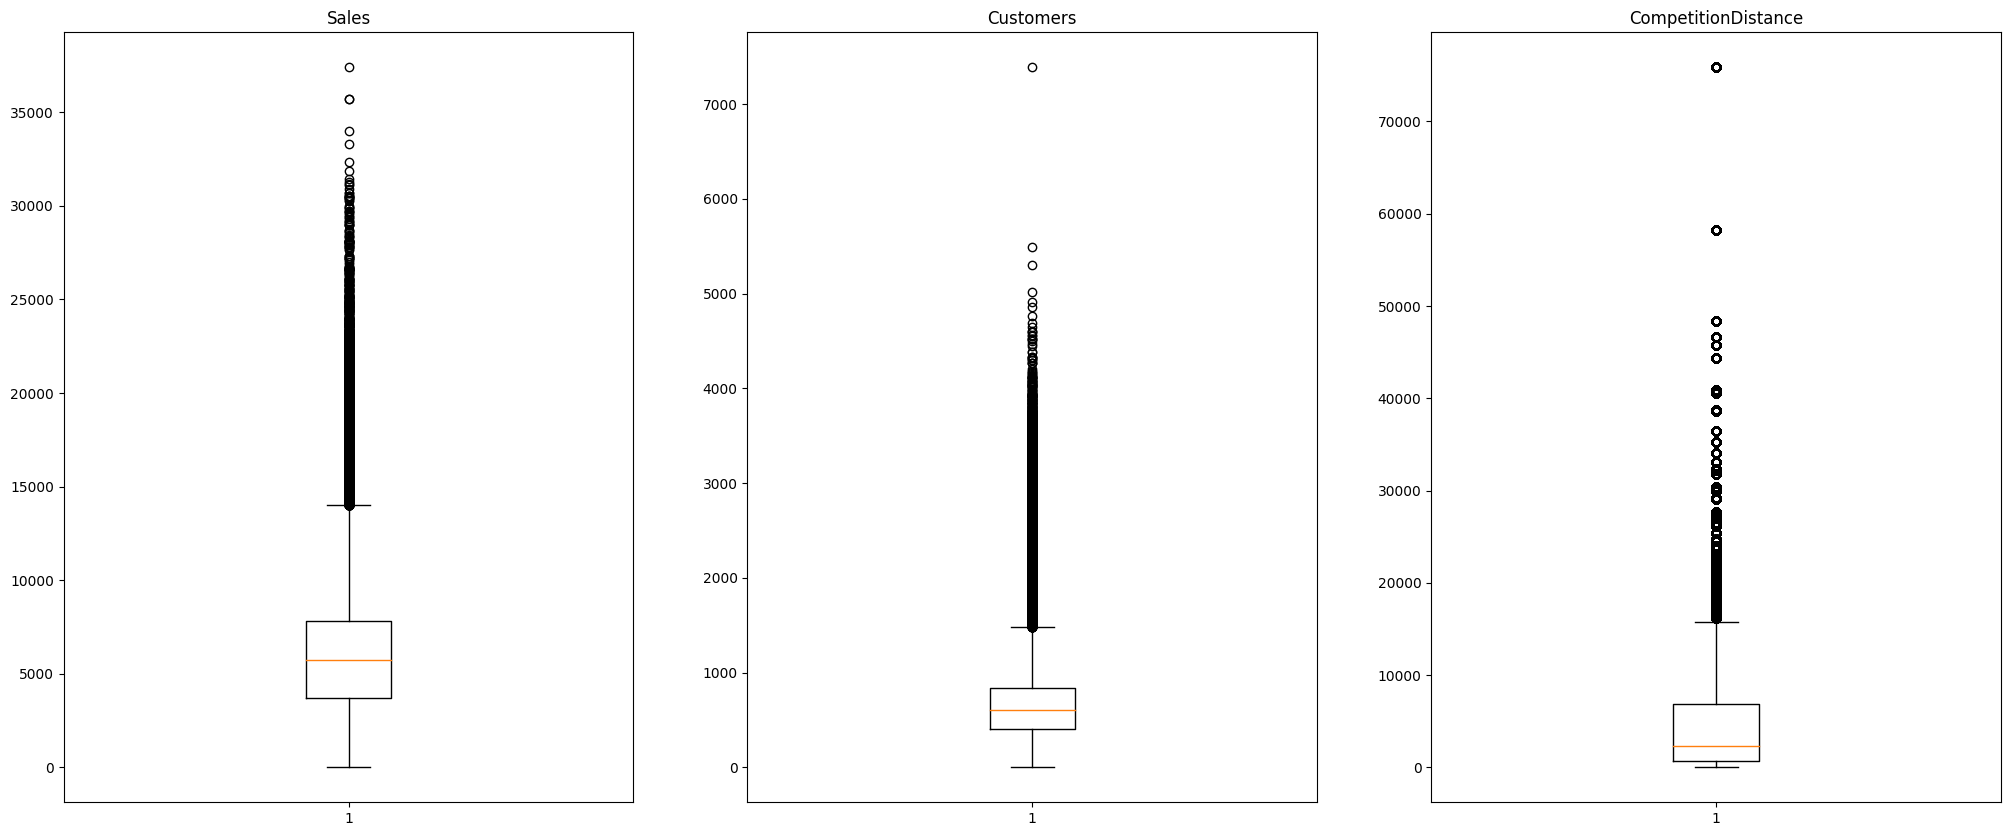

Aykırı değer yüzdeleri
Sales: 0.03
Customers: 0.04
Distance: 0.1


In [1]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score,KFold,GridSearchCV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor
import sklearn.metrics as mt
from sklearn.decomposition import PCA

df_zip=zipfile.ZipFile("/content/rossman.zip")
train=pd.read_csv(df_zip.open("train.csv"),low_memory=False)
store=pd.read_csv(df_zip.open("store.csv"),low_memory=False)

# Değişkenler:

"""
 train dataset:
* store: mağaza idler
* DayOfWeek: haftanın gunu
* Date: Tarih
* Sales: Ciro (verilen tarihteki)
* Customers: Müşteri sayısı
* Open: mağazanın açık olup olmaması durumu
* Promo: O mağazanın o gün içerisinde kampanya yapıp yapmaması.
* StateHoliday: resmi tatil. (a=resmi tatil, b=pascalya, c=noel, 0= bunların dısında)
* SchoolHoliday: o bölgedeki okulların o tarihte açık olup olmaması

 store dataset:
* Store: mağaza id
* StoreType: Mağaza kategorileri (a,b,c,d)
* Assortment: Mağazaların ürün çeşitliliğini kategorize etmiş bir değişken. (a=temel ürünler, b=ekstra ürünler, c=genişletilmiş ürün yapısı)
* CompetitionDistance: Metre cinsinden veri. Rakip firmanın bize en yakın mağzasının bize olan uzaklığı.
* CompetitionOpenSinceMonth: En yakın rakip firmanın açıldığı ay
* CompetitionOpenSinceYear: En yakın rakip firmanın açıldığı yıl
* Promo2: Tüm mağzaları kapsayan promosyon yapısı (genel). Genel bir kampanya var ve her mağza buna katılmak zorunda değil. 0 katılmadı, 1 katıldı.
* Promo2SinceWeek: Promosyon sürecine katılınan hafta.
* Promo2SinceYear: Promosyon sürecine katılınan yıl.
* PromoInterval: Ay bazında promosyonun başlangıç ayları ve yenileme süreçleri.
"""

veri=train.merge(store,on="Store",how="inner")

# veri türleri düzenleme:
veri["Date"]=pd.to_datetime(veri["Date"],infer_datetime_format=True)
veri["Gün"]=veri["Date"].dt.day
veri["Hafta"]=veri["Date"].dt.week
veri["Ay"]=veri["Date"].dt.month
veri["Yıl"]=veri["Date"].dt.year
# Mevsimler:
veri["Mevsim"]=np.where(veri["Ay"].isin([3,4,5]),"İlkbahar",
                       np.where(veri["Ay"].isin([6,7,8]),"Yaz",
                               np.where(veri["Ay"].isin([9,10,11]),"Sonbahar",
                                       np.where(veri["Ay"].isin([12,1,2]),"Kış","None"))))

veri[["Date","Gün","Hafta","Ay","Yıl","Mevsim"]]

# Eksik Değerler ve Veri tipleri:

print(veri.isnull().sum()/veri.shape[0]*100)
veri["CompetitionDistance"]=veri["CompetitionDistance"].fillna(veri["CompetitionDistance"].mode()[0])

veri2=veri.sample(frac=0.2,replace=True,random_state=1) # rassal olarak veri setinin %20'sini aldık
veri2=veri2.reset_index()
veri2=veri2.drop(columns="index")
print(veri2.shape)

nc=["Sales","Customers","CompetitionDistance"] # sayısal değişkenler
kc=["DayOfWeek","Open","Promo","SchoolHoliday","StateHoliday","StoreType","Assortment","Hafta","Ay","Yıl","Mevsim","Promo2"] # kategorik değişkenler

veri2[kc]=veri2[kc].astype("object")
print(veri2.info())

## Encoding:

le=LabelEncoder()
veri2.update(veri2[kc].apply(le.fit_transform))

t2=veri2[nc]
t3=veri2[kc]
t3=pd.concat([t2,t3],axis=1)
t3=t3.reset_index()
t3=t3.drop(columns="index")
print(t3.head())

# Aykırı Gözlemlerin tespiti ve baskılanması

fig,ax=plt.subplots(1,3,figsize=(25,10))
ax[0].boxplot(t3["Sales"])
ax[0].set_title("Sales")
ax[1].boxplot(t3["Customers"])
ax[1].set_title("Customers")
ax[2].boxplot(t3["CompetitionDistance"])
ax[2].set_title("CompetitionDistance")
plt.show()

def aykiri_index(data,col):
    q1=data[col].quantile(0.25)
    q3=data[col].quantile(0.75)
    IQR=q3-q1

    altsinir=q1-1.5*IQR
    ustsinir=q3+1.5*IQR

    aykırımin=data[data[col]<altsinir][col]
    aykırımax=data[data[col]>ustsinir][col]

    aykırı=pd.concat([aykırımin,aykırımax], axis=0).index
    return aykırı, altsinir, ustsinir
    
aykiri_sales_index=aykiri_index(t3,"Sales")[0]
aykiri_customers_index=aykiri_index(t3,"Customers")[0]
aykiri_distance_index=aykiri_index(t3,"CompetitionDistance")[0]

print("Aykırı değer yüzdeleri\nSales: {}\nCustomers: {}\nDistance: {}".format(round(len(aykiri_sales_index)/len(veri2),2),round(len(aykiri_customers_index)/len(veri2),2),round(len(aykiri_distance_index)/len(veri2),2)))

t3.loc[t3["Sales"]<aykiri_index(t3,"Sales")[1]]=aykiri_index(t3,"Sales")[1]
t3.loc[t3["Sales"]>aykiri_index(t3,"Sales")[2]]=aykiri_index(t3,"Sales")[2]
t3.loc[t3["Customers"]<aykiri_index(t3,"Customers")[1]]=aykiri_index(t3,"Customers")[1]
t3.loc[t3["Customers"]>aykiri_index(t3,"Customers")[2]]=aykiri_index(t3,"Customers")[2]
t3.loc[t3["CompetitionDistance"]<aykiri_index(t3,"CompetitionDistance")[1]]=aykiri_index(t3,"CompetitionDistance")[1]
t3.loc[t3["CompetitionDistance"]>aykiri_index(t3,"CompetitionDistance")[2]]=aykiri_index(t3,"CompetitionDistance")[2]
y=t3["Sales"]
t3=t3.drop(columns="Sales")

## Standartlaştırma:

sc=StandardScaler()
X=sc.fit_transform(t3)


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)


# Hiper parametre tuning:

modeller=["DecisionTreeRegressor","BaggingRegressor","RandomForestRegressor"]
regresyonlar=[DecisionTreeRegressor(random_state=0),BaggingRegressor(random_state=0),RandomForestRegressor(random_state=0)]
parametreler={
    modeller[0]:{"min_samples_split":range(2,25),"max_leaf_nodes":range(2,25)},
    modeller[1]:{"n_estimators":range(2,25)},
    modeller[2]:{"max_depth":range(2,25),"max_features":range(2,25),"n_estimators":range(2,25)}
}

def cozum(model):
    model.fit(X_train,y_train)
    return model

def skor(model2):
    tahmin=cozum(model2).predict(X_test)
    r2=mt.r2_score(y_test,tahmin)
    rmse=mt.mean_squared_error(y_test,tahmin,squared=True)
    return [r2,rmse]

#for i,j in zip(modeller,regresyonlar):
    #print(i)
    #grid=GridSearchCV(cozum(j),parametreler[i],cv=3)
    #grid.fit(X_train,y_train)
    #print(grid.best_params_)

In [2]:
regresyonlar2=[DecisionTreeRegressor(random_state=0,max_leaf_nodes=24,min_samples_split=2),BaggingRegressor(random_state=0,n_estimators=24),RandomForestRegressor(random_state=0,max_depth=13,max_features=2,n_estimators=19)]
sonuc=[]

for i in regresyonlar2:
    sonuc.append(skor(i))

df=pd.DataFrame(modeller,columns=["Model Adı"])
df2=pd.DataFrame(sonuc,columns=["R2","RMSE"])

df=df.join(df2)
print(df)

               Model Adı        R2          RMSE
0  DecisionTreeRegressor  0.945869  1.053702e+06
1       BaggingRegressor  0.985554  2.812058e+05
2  RandomForestRegressor  0.952119  9.320263e+05


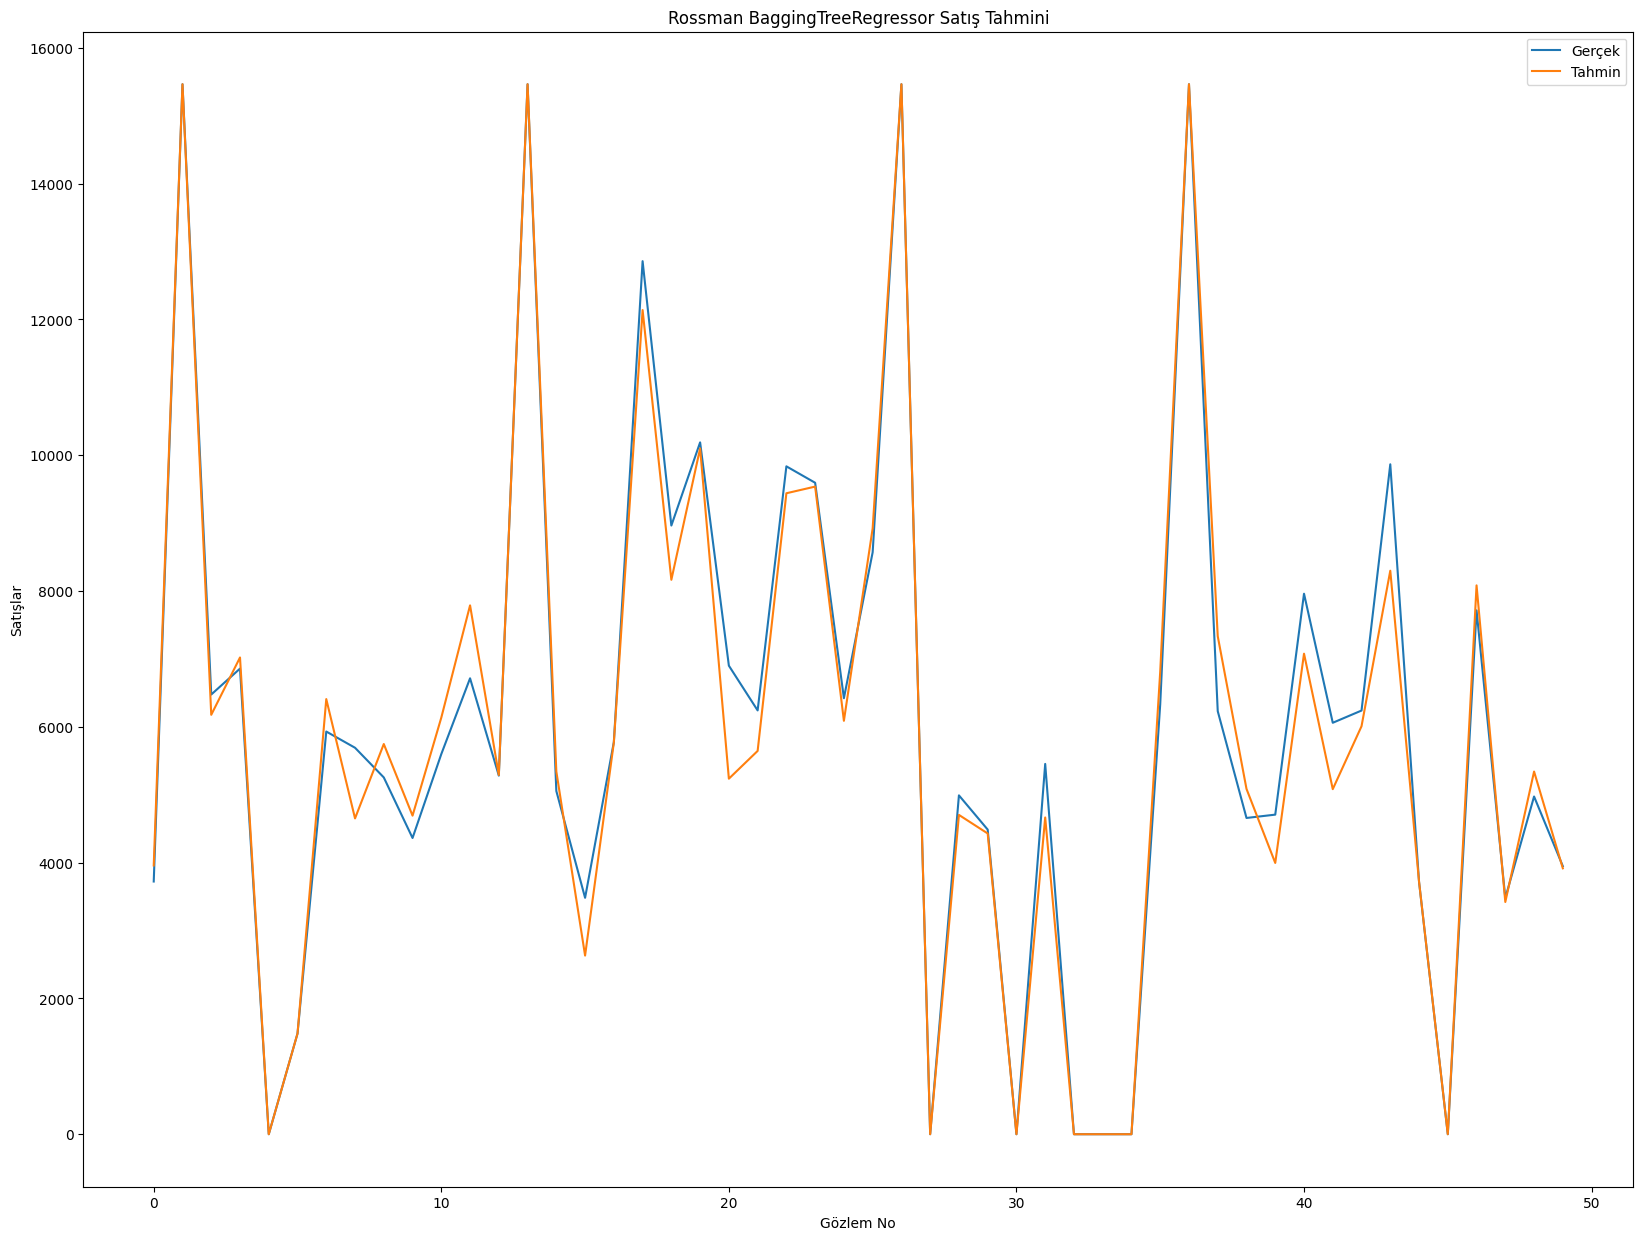

In [3]:
bgmodel=BaggingRegressor(random_state=0,n_estimators=24)
bgmodel.fit(X_train,y_train)
bgtahmin=bgmodel.predict(X_test)

plt.figure(figsize=(20,15))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Gerçek")
plt.plot(range(len(y_test[:50])),bgtahmin[:50],label="Tahmin")
plt.title("Rossman BaggingTreeRegressor Satış Tahmini")
plt.ylabel("Satışlar")
plt.xlabel("Gözlem No")
plt.legend()
plt.show()

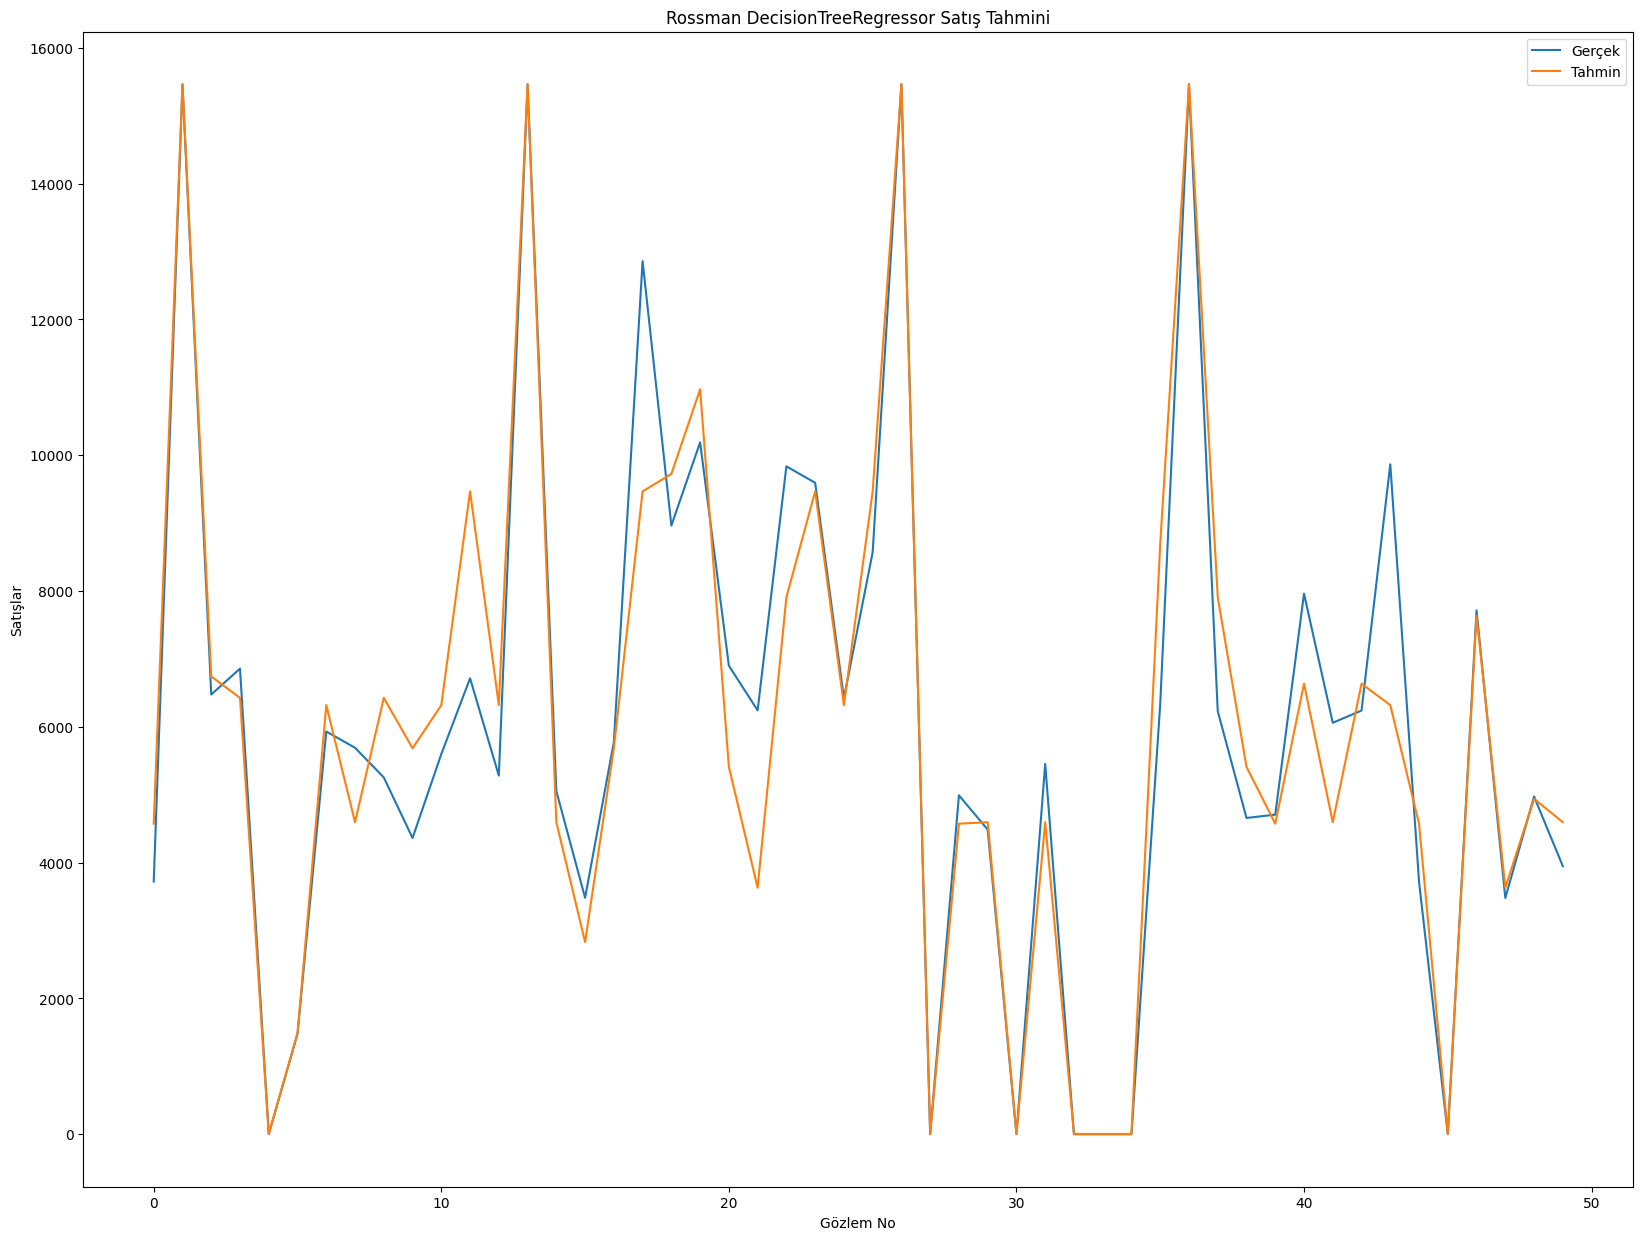

In [5]:
dtmodel=DecisionTreeRegressor(random_state=0,max_leaf_nodes=24,min_samples_split=2)
dtmodel.fit(X_train,y_train)
dttahmin=dtmodel.predict(X_test)

plt.figure(figsize=(20,15))
plt.plot(range(len(y_test[:50])),y_test[:50],label="Gerçek")
plt.plot(range(len(y_test[:50])),dttahmin[:50],label="Tahmin")
plt.title("Rossman DecisionTreeRegressor Satış Tahmini")
plt.ylabel("Satışlar")
plt.xlabel("Gözlem No")
plt.legend()
plt.show()